# Retrieve spectra from HEASARC using Simple Spectral Access protocol

This notebook is one of a set produced by the HEASARC to demonstrate data access with python tools. If you have not already, start with the [overview notebook](heasarc_queries_Overview.ipynb)

In [1]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  
import requests, io
from astropy.table import Table

import xspec
## For capturing Xspec terminal output
##  See https://github.com/minrk/wurlitzer
from wurlitzer import sys_pipes
## Hide annoying warnings
import warnings
warnings.filterwarnings("ignore")

from astropy.coordinates import SkyCoord


## Find out what catalogs of spectra can be queried with HEASARC's SSA service:

In [2]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,a.ivoid from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simplespectralaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
##  If you want to see what requests gives you, you can look at the URL it actually constructed:
#print(r.url)
##  And the raw text of what it got back:
# print(r.text)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
table=Table.read(io.BytesIO(r.content))
table

short_name,ivoid
object,object
Chandra,ivo://nasa.heasarc/chanmaster
INTEGRAL/BSC,ivo://nasa.heasarc/intbsc
SwiftBAT,ivo://nasa.heasarc/swiftbalog
SwiftXRT,ivo://nasa.heasarc/swiftxrlog


## Query one of them, in this case Chandra for the source M82:

In [4]:
## Sometimes this does nothing but time out!
#import astropy.coordinates as coord
#m82=coord.SkyCoord.from_name("m82")
#pos='{},{}'.format(m82.ra.deg,m82.dec.deg)
pos='148.968458,69.679703' # M82
#pos='83.633083,22.014500' # crab
#pos='191.542417,30.731583' #mice
params = {'table': 'chanmaster',"POS":pos,"SIZE":"0.1", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
#print(r.content)
spec_table = Table.read(io.BytesIO(r.content))
spec_table['time'].format='.4f'
spec_table.show_in_notebook()

idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_datalength,SSA_datamodel,SSA_title,SSA_instrument,SSA_publisher,SSA_tmid,SSA_stop_time,SSA_start_time,SSA_duration,SSA_bandpass,SSA_wavelength_max,SSA_wavelength_min,SSA_bandwidth,SSA_ra,SSA_dec,SSA_coord_obs,SSA_fov,SSA_reference,SSA_format
,,,,deg,deg,mjd,,,s,,,mjd,,,,,,mjd,mjd,mjd,s,meter,meter,meter,meter,deg,deg,deg,deg,,
0,17860,archived,M82 X-1,148.95917,69.67972,57639.7292,ACIS-S,HETG,51060,TOO,Walton,58010,12.0,Spectrum-1.0,acisf17860N002_pha2,ACIS-S,HEASARC,57640.040393247451,57640.350814633915,57639.729200000002,51060.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,application/fits
1,19791,archived,M82 X-1,148.95917,69.67972,57641.5702,ACIS-S,HETG,15310,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19791N002_pha2,ACIS-S,HEASARC,57641.668022753758,57641.765065583451,57641.570200000002,15310.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,application/fits
2,19792,archived,M82 X-1,148.95917,69.67972,57642.3530,ACIS-S,HETG,32440,TOO,Walton,58010,12.0,Spectrum-1.0,acisf19792N002_pha2,ACIS-S,HEASARC,57642.558369954859,57642.762945849187,57642.353000000003,32440.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,148.95917,69.679720000000003,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,application/fits


## Retrieve one of the spectra:

In [5]:
## Get the first spectrum (which has a long-ish exposure.)
import astropy.io.fits as fits
hdu_list=fits.open(spec_table[2]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table.show_in_notebook()



idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
1,2,-2,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
2,3,-1,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
3,4,1,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
4,5,2,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
5,6,3,1,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
6,7,-3,2,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,13.985 .. 0.333333333333,13.9866666667 .. 0.335
7,8,-2,2,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,20.9775 .. 0.5,20.98 .. 0.5025
8,9,-1,2,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005
9,10,1,2,1,4105.62,4071.5,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005


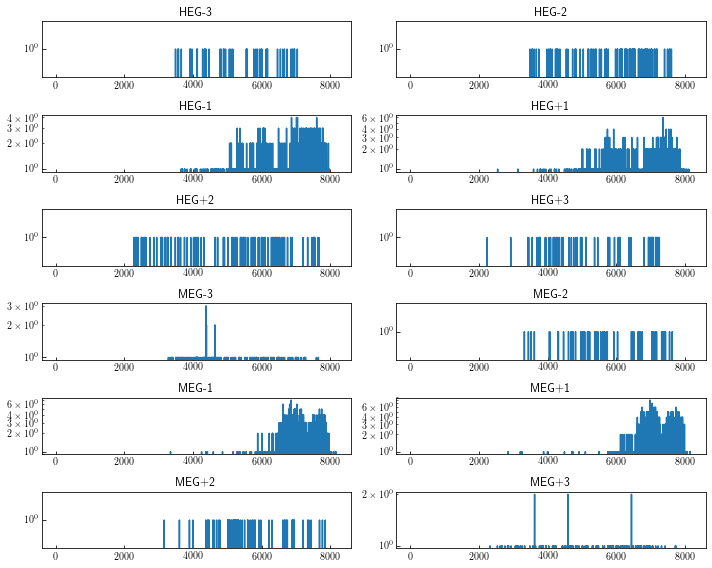

In [17]:
## Here, you just have to be familiar with the format of these spectra by reading Chandra documentation.
for i in range(len(table)):
    matplotlib.rcParams['figure.figsize'] = (10, 8)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')
    if table['TG_PART'][i] == 1:
        instr='HEG'
    if table['TG_PART'][i] == 2:
        instr='MEG'
    if table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title("{grating}{order:+d}".format(grating=instr, order=table['TG_M'][i]))
    plt.tight_layout()
    

Note: The 12 plots here show all the different HEG and MEG components (+/- 3, +/- 2, and +/- 1 for each grating) for the grating data, as titled. In practice, you might want to download the fits file and use a different analysis and plotting tool to create an energy spectrum plot using SHERPA or XSPEC, etc. 

You can download the file directly using this:


In [18]:
## Because urllib is annoying to make Python 2/3 compatible, just use requests:
r=requests.get(spec_table[2]['SSA_reference'].decode(), stream=True)
with open('my_spectrum.fits','wb') as f:
    f.write(r.content)

## Analyze it with PyXspec

<div>
Note that currently, we do not have a way to link the spectra to their corresponding response files.  In some cases, you can take the download URL for the spectrum and look for the response in the same directory, but this is obviously not ideal.  In other cases, it's even less obvious how to find the correct response.  A knowledge of the specific mission archive and tools is currently necessary.  For this example, we have retrieved off-line the relevant file and stored it as "my_arf.fits".  This is an issue to be addressed by the HEASARC in the future to make this process more feasible. For now, this example is a proof-of-concept only.  
</div>

In [19]:
xspec.Xset.allowPrompting = False # keeps pyxspec from hanging, waiting for a response to a prompt
##  The type II PHA files contain multiple spectra, and we tell Xspec to select with the 
##  curly bracket notation and the number starting from 1 (not zero):
with sys_pipes():
    pha = xspec.Spectrum("my_spectrum.fits{10}")
    ##  As mentioned above, this is retrieved off-line for now.
    #pha.response="tgcat/obs_19792_tgid_5277/heg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/heg_1.arf.gz"    
    #pha.response="tgcat/obs_19792_tgid_5277/meg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/meg_1.arf.gz"
    pha.response="my_rmf.fits.gz"
    pha.response.arf="my_arf.fits.gz"


1 spectrum  in use
 
Spectral Data File: my_spectrum.fits{10}  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.696e-02 +/- 5.616e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-8192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 3.202e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.
Arf successfully loaded.


In [20]:
with sys_pipes():
    m = xspec.Model("wa*po + ga")


Model wabs<1>*powerlaw<2> + gaussian<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   5    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   6    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic : Chi-Squared =   1.807228e+08 using 8192 PHA bins.

Test statistic : Chi-Squared =   1.807228e+08 using 8192 PHA bins.
 Reduced chi-squared =       22077.06 for   8186 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.


In [21]:
with sys_pipes():
    xspec.Fit.statMethod ="cstat"
    xspec.Fit.perform()

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic : C-Statistic =   1.888737e+06 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not Poisson


Test statistic : Chi-Squared =   1.807228e+08 using 8192 PHA bins.
 Reduced chi-squared =       22077.06 for   8186 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH    2:PhoIndex        3:norm       4:LineE       5:Sigma        6:norm
2499.1       16929        -3      0.881410       1.44961    0.00310024       7.35795       1.32969    0.00111798
2450.56      8181.8       -4      0.745761       1.44208    0.00313374       9.50993       2.30546    0.00107631
2448.72      369.728      -2      0.649951       1.31388    0.00276595       13.4244       1.78921    0.00269712
2447.51      1727.98      -3      0.603554       

<font color='red'> Need error bars and maybe a better model?</font>

We can plot the results using, e.g., matplotlib (first example below) or Xspec's own plotting routines (second example below):

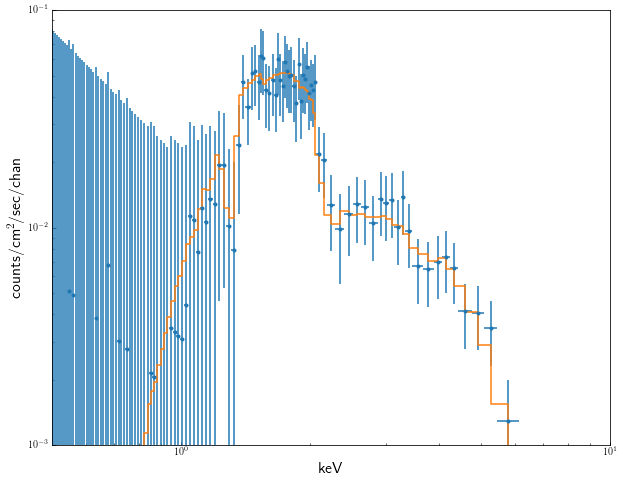

In [22]:
xspec.Plot.device = "/nu"

ax = plt.subplot(111)

from astropy.convolution import convolve, Box1DKernel
import numpy as np
nbins=50 # Boxcar width
plt.rcParams['figure.figsize'] = (10, 4)

## This tells xspec.Plot that you want to use energy for the x-axis; otherwise, you get channel.
xspec.Plot.xAxis = "keV"
xspec.Plot.setRebin(minSig=3.0, maxBins=50)
xspec.Plot("data")
xVals = xspec.Plot.x()
xValserr = xspec.Plot.xErr()
yVals = xspec.Plot.y()
yValserr = xspec.Plot.yErr()

modVals = xspec.Plot.model()

## Boxcar the data so the trend is visible:
#plotY=convolve(np.asarray(yVals),  Box1DKernel(nbins))
#plotM=convolve(np.asarray(modVals),Box1DKernel(nbins))

plt.errorbar(xVals, yVals, yerr=yValserr, xerr=xValserr, fmt='.')

plt.step(xVals, modVals)
plt.xlabel('keV', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
ax.set_yscale('log')
ax.set_ylim([1e-3,1e-1])
ax.set_xlim([0.5,10])
ax.set_xscale('log')


# Chandra Spectrum of Delta Ori

In [26]:
delori=SkyCoord.from_name("delta ori")
pos='{},{}'.format(delori.ra.deg,delori.dec.deg)

params = {'table': 'chanmaster',"POS":pos,"SIZE":"0.1", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
#print(r.content)
spec_table = Table.read(io.BytesIO(r.content))
spec_table['time'].format='.4f'
spec_table.show_in_notebook()

idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_datalength,SSA_datamodel,SSA_title,SSA_instrument,SSA_publisher,SSA_tmid,SSA_stop_time,SSA_start_time,SSA_duration,SSA_bandpass,SSA_wavelength_max,SSA_wavelength_min,SSA_bandwidth,SSA_ra,SSA_dec,SSA_coord_obs,SSA_fov,SSA_reference,SSA_format
,,,,deg,deg,mjd,,,s,,,mjd,,,,,,mjd,mjd,mjd,s,meter,meter,meter,meter,deg,deg,deg,deg,,
0,639,archived,DELTA ORI,83.00125,-0.29917,51556.1364,ACIS-S,HETG,49680,GO,Cassinelli,52037,12.0,Spectrum-1.0,acisf00639N004_pha2,ACIS-S,HEASARC,51556.436500571508,51556.735856340485,51556.136400000003,49680.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001249999999999,-0.29916999999999999,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat2/639/primary/acisf00639N004_pha2.fits.gz,application/fits
1,7416,archived,delta Ori HD 36486,83.00167,-0.29908,54413.4270,HRC-S,LETG,97080,GO,Raassen,54783,2.0,Spectrum-1.0,hrcf07416N003_pha2,HRC-S,HEASARC,54413.997480954342,54414.567153797223,54413.427000000003,97080.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001670000000004,-0.29908000000000001,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat2/7416/primary/hrcf07416N003_pha2.fits.gz,application/fits
2,14567,archived,Delta Ori,83.00167,-0.29908,56280.7037,ACIS-S,HETG,116500,GO,Corcoran,56647,12.0,Spectrum-1.0,acisf14567N002_pha2,ACIS-S,HEASARC,56281.389824722108,56282.075177840627,56280.703699999998,116500.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001670000000004,-0.29908000000000001,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14567/primary/acisf14567N002_pha2.fits.gz,application/fits
3,14568,archived,Delta Ori,83.00167,-0.29908,56288.1612,ACIS-S,HETG,123600,GO,Corcoran,56655,12.0,Spectrum-1.0,acisf14568N002_pha2,ACIS-S,HEASARC,56288.890250763019,56289.618502032063,56288.161200000002,123600.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001670000000004,-0.29908000000000001,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14568/primary/acisf14568N002_pha2.fits.gz,application/fits
4,14569,archived,Delta Ori,83.00167,-0.29908,56283.2540,ACIS-S,HETG,120850,GO,Corcoran,56650,12.0,Spectrum-1.0,acisf14569N002_pha2,ACIS-S,HEASARC,56283.964980170487,56284.675201996994,56283.254000000001,120850.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001670000000004,-0.29908000000000001,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14569/primary/acisf14569N002_pha2.fits.gz,application/fits
5,14570,archived,Delta Ori,83.00167,-0.29908,56285.5508,ACIS-S,HETG,124100,GO,Corcoran,56652,12.0,Spectrum-1.0,acisf14570N002_pha2,ACIS-S,HEASARC,56286.283897468573,56287.016223824656,56285.550799999997,124100.0,3.16159e-09,6.1991999999999999e-09,1.2397999999999999e-10,6.0752199999999996e-09,83.001670000000004,-0.29908000000000001,--,0.81103500403976259,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14570/primary/acisf14570N002_pha2.fits.gz,application/fits


In [66]:
## Get the first spectrum (which has a long-ish exposure.)
hdu_list=fits.open(spec_table[5]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table.show_in_notebook()

idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
1,2,-2,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
2,3,-1,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
3,4,1,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,21.4775 .. 1.0,21.48 .. 1.0025
4,5,2,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,10.73875 .. 0.5,10.74 .. 0.50125
5,6,3,1,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,7.15916666667 .. 0.333333333333,7.16 .. 0.334166666667
6,7,-3,2,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,13.985 .. 0.333333333333,13.9866666667 .. 0.335
7,8,-2,2,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,20.9775 .. 0.5,20.98 .. 0.5025
8,9,-1,2,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005
9,10,1,2,1,4113.77,4083.73,1 .. 8192,0 .. 0,1.86603 .. 1.86603,0 .. 0,0 .. 0,41.955 .. 1.0,41.96 .. 1.005


In [27]:
## Because urllib is annoying to make Python 2/3 compatible, just use requests:
r=requests.get(spec_table[5]['SSA_reference'].decode(), stream=True)
with open('delori_spectrum.fits','wb') as f:
    f.write(r.content)

In [40]:
with sys_pipes():
    xspec.AllData.clear()
    xspec.AllData += "delori_spectrum.fits{10}"
    pha = xspec.AllData(1)
    pha.response="14570/meg_1.rmf.gz"
    pha.response.arf="14570/meg_1.arf.gz"


1 spectrum  in use
 
Spectral Data File: delori_spectrum.fits{10}  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.140e-02 +/- 1.529e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-8192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.225e+05 sec
 Using fit statistic: cstat
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

Fit statistic : C-Statistic =       18492.77 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not Poisson


Test statistic : Chi-Squared =        1269.92 using 8192 PHA bins.
 Reduced chi-squared =       0.155134 for   8186 degrees of freedom 
 Null hypothesis probability =   1.000000e+00
 Current data and model not fit yet.
Arf successfully loaded.

Fit statistic : C-Statistic =       16773.72 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not 

In [41]:
with sys_pipes():
    m = xspec.Model("TBabs*apec + TBabs*apec")
    m.apec.kT = [.1,.01,.05,.05,1,1]
    m.apec.norm = 5e-4
    m.apec_4.kT = [1,.01,.7,.7,4,4]
    m.apec_4.norm = 1e-3
    m.TBabs.nH = [.01,0.01,0.0,0.0,.4,.4]
    m.TBabs_3.nH = [.01,0.01,0.0,0.0,.4,.4]




Model TBabs<1>*apec<2> + TBabs<3>*apec<4> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   apec       kT         keV      1.00000      +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                1.00000      +/-  0.0          
   6    3   TBabs      nH         10^22    1.00000      +/-  0.0          
   7    4   apec       kT         keV      1.00000      +/-  0.0          
   8    4   apec       Abundanc            1.00000      frozen
   9    4   apec       Redshift            0.0          frozen
  10    4   apec       norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic : C-Statistic =   2.418551e+06 using 8192 PHA bins and 8186 degrees of freedom.


In [42]:
with sys_pipes():
    pha.show()
    m.show()

Spectrum 1  Spectral Data File: delori_spectrum.fits{10}
Net count rate (cts/s) for Spectrum:1  3.140e-02 +/- 1.529e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-8192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.225e+05 sec
 Using fit statistic: cstat
 Using test statistic: chi
 Using Response (RMF) File            14570/meg_1.rmf.gz for Source 1
 Using Auxiliary Response (ARF) File  14570/meg_1.arf.gz

 Spectral data counts: 3846
 Model predicted rate: 1.98758E-02


Model TBabs<1>*apec<2> + TBabs<3>*apec<4> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000E-02  +/-  0.0          
   2    2   apec       kT         keV      0.100000     +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                5.00000E-04  +/-  0.0      

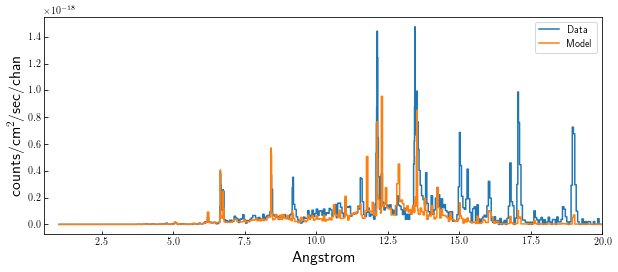

In [43]:
xspec.Plot.device = "/nu"
xspec.Plot.xAxis = "Angstrom"
xspec.Plot.setRebin(minSig=3.0, maxBins=10)
xspec.Plot("data")
xVals = xspec.Plot.x()
xValserr = xspec.Plot.xErr()
yVals = xspec.Plot.y()
yValserr = xspec.Plot.yErr()

modVals = xspec.Plot.model()

## Boxcar the data so the trend is visible:
#plotY=convolve(np.asarray(yVals),  Box1DKernel(nbins))
#plotM=convolve(np.asarray(modVals),Box1DKernel(nbins))

#plt.errorbar(xVals, yVals, yerr=yValserr, xerr=xValserr, fmt='.')

plt.step(xVals, yVals, label='Data')

plt.step(xVals, modVals, label="Model")
plt.xlabel('Angstrom', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
plt.legend()
plt.yscale('linear')
#plt.ylim([1e-5,10])
plt.xlim([0.5,20])
plt.xscale('linear')



In [44]:
with sys_pipes():
    xspec.Fit.statMethod ="cstat"
    xspec.Fit.perform()

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic : C-Statistic =        7100.85 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not Poisson


Test statistic : Chi-Squared =        1079.12 using 8192 PHA bins.
 Reduced chi-squared =       0.131825 for   8186 degrees of freedom 
 Null hypothesis probability =   1.000000e+00
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH          2:kT        5:norm          6:nH          7:kT       10:norm
5091.31      3084.19      -2      0.221152      0.268139    0.00471159   0.000447569      0.877661    0.00122596
5051.94      55297.8      -2      0.282899      0.226126    0.00912306     0.0545361      0.881539   0.000963671
4947.97      48429.7      -3      0.273577      0.232091     0.0109706     0.0850835      0.873139    0.00104697
4945.6       4056.14      -4      0.270935      0

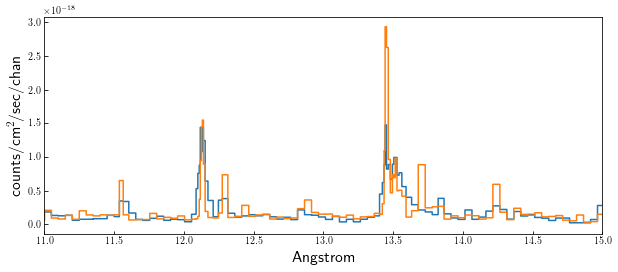

In [47]:
xspec.Plot.device = "/nu"

ax = plt.subplot(111)

plt.rcParams['figure.figsize'] = (10, 4)

## This tells xspec.Plot that you want to use energy for the x-axis; otherwise, you get channel.
xspec.Plot.xAxis = "Angstrom"
xspec.Plot.setRebin(minSig=3.0, maxBins=10)
xspec.Plot("data")
xVals = xspec.Plot.x()
xValserr = xspec.Plot.xErr()
yVals = xspec.Plot.y()
yValserr = xspec.Plot.yErr()

modVals = xspec.Plot.model()

## Boxcar the data so the trend is visible:
#plotY=convolve(np.asarray(yVals),  Box1DKernel(nbins))
#plotM=convolve(np.asarray(modVals),Box1DKernel(nbins))

#plt.errorbar(xVals, yVals, yerr=yValserr, xerr=xValserr, fmt='.')

plt.step(xVals, yVals)

plt.step(xVals, modVals)
plt.xlabel('Angstrom', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
ax.set_yscale('linear')
#ax.set_ylim([1e-3,1e-1])
ax.set_xlim([11,15])
ax.set_xscale('linear')
